# update GOCI-II crawler
The [GK2B_crawler.ipynb](https://github.com/chhyyi/aiffelthon/blob/main/GK2B_crawler.ipynb) just look for & download files on web page provided by OpenDAP.
I've just converted that as a python module.

In [20]:
from rz_cvae.Crawler import Crawler
# example: download jpgs
crawler=Crawler(slot=7, product='Chl')
# crawler.get_files()

initialized crawler with
                date: 2021/01/01 ~ 2021/01/02	downlad_dir: outputs	product: Chl	file_type: nc	dap_web: http://nosc.elecocean.co.kr:8080/opendap/GOCI-II/


processing date 20210101
pathlist: ['GK2_GC2_L2_20210101_001530/contents.html', 'GK2_GC2_L2_20210101_011530/contents.html', 'GK2_GC2_L2_20210101_021530/contents.html', 'GK2_GC2_L2_20210101_031530/contents.html', 'GK2_GC2_L2_20210101_041530/contents.html', 'GK2_GC2_L2_20210101_051530/contents.html', 'GK2_GC2_L2_20210101_061530/contents.html', 'GK2_GC2_L2_20210101_071530/contents.html', 'GK2_GC2_L2_20210101_081530/contents.html', 'GK2_GC2_L2_20210101_231530/contents.html']
searching http://nosc.elecocean.co.kr:8080/opendap/GOCI-II/2021/01/01/L2/GK2_GC2_L2_20210101_001530/contents.html page includes LA_S007_Chl.nc
pathlist: []
searching http://nosc.elecocean.co.kr:8080/opendap/GOCI-II/2021/01/01/L2/GK2_GC2_L2_20210101_081530/contents.html page includes LA_S007_Chl.nc
pathlist: ['GK2B_GOCI2_L2_20210101_081530_LA_

In [4]:
import datetime
import numpy as np
import netCDF4 as nc4
import matplotlib.pyplot as plt
import pandas as pd
import os

In [5]:
# load netCDF4 file...
rootgrp = nc4.Dataset('./outputs/GK2B_GOCI2_L2_20210102_071530_LA_S007_RI.nc')
print(rootgrp)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6 ACDD-1.3
    acknowledgement: 
    comment: 
    creator_email: kosc@kiost.ac.kr
    creator_name: KOSC
    creator_url: http://kosc.kiost.ac.kr
    earth_radius: 6378137.0
    false_easting: 0.0
    false_northing: 0.0
    geographic_crs_name: WGS 84
    geospatial_lat_max: 39.28563
    geospatial_lat_min: 30.665466
    geospatial_lat_resolution: 250 meters
    geospatial_lat_units: degree_north
    geospatial_lon_max: 130.40538
    geospatial_lon_min: 121.99647
    geospatial_lon_resolution: 250 meters
    geospatial_lon_units: degree_east
    grid_mapping_name: geostationary
    history: input:AC,STATIC__output:RI
    horizontal_datum_name: WGS 1984
    id: GK2B_GOCI2_L2_20210102_071530_LA_S007_RI.nc
    image_center_latitude: 34.785534
    image_center_longitude: 126.338715
    image_lowerright_latitude: 30.66906
    image_lowerright_longitude: 130.15741
    image_upperleft

In [14]:
os.path.basename('./outputs/GK2B_GOCI2_L2_20210102_071530_LA_S007_RI.nc')

'GK2B_GOCI2_L2_20210102_071530_LA_S007_RI.nc'

## Informations on NetCDF file

### Some notable informations
- on root:
    - geographic_crs_name: WGS 84
    - observation_end_time, observation_start_time: 20210102_072653 (maybe YYYYMMDD_HHMMSS)
- on root/geophysical_data/flag:  
    - flags
    - 2-D array of the flag
- on root/geophysical_data/product_name (for example, rootgrp['geophysical_data']['RI'])
    - _FillValue: -32768.0
    - 2-D array of the current product
- on root/navigation_data: It shows latitude&longitude of every elements of array.   
    (For example, on slot7, dimension of navigation data is $2780 \times 2780 \times 2$ as dimension of slot7 is $2780 \times 2780$,)

### mask formatting
flag mask: binary digits shows each flag, same dimension with product array.  
Flag on n-th digit is $floor\left(\frac{x \bmod 2^{n+1}}{2^n}\right)$ where $x$ is the value of each 2-D array element and $n$ is order of flag(1,2,3,4...)  
Or  $floor\left(\frac{x \bmod (2m)}{m}\right)$ where m is flag mask(1,2,4,8...)

In [14]:
rootgrp['navigation_data']

<class 'netCDF4._netCDF4.Group'>
group /navigation_data:
    dimensions(sizes): 
    variables(dimensions): float32 latitude(number_of_lines, pixels_per_line), float32 longitude(number_of_lines, pixels_per_line)
    groups: 

In [7]:
data=rootgrp['geophysical_data']['flag']
data

<class 'netCDF4._netCDF4.Variable'>
uint8 flag(number_of_lines, pixels_per_line)
    flag_masks: [  1   2   4   8  16  32  64 128]
    flag_meanings: Cloud_or_Ice Land AC_Fail reserved4 reserved5 reserved6 reserved7 reserved8
path = /geophysical_data
unlimited dimensions: 
current shape = (2780, 2780)
filling on, default _FillValue of 255 ignored

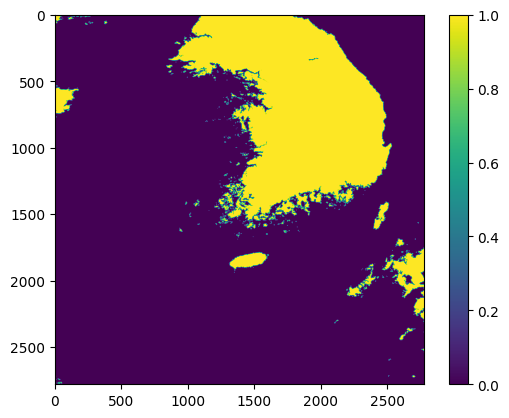

In [4]:
data=rootgrp['geophysical_data']['flag']
data=(np.array(data)%4)//2
plt.imshow(data)
plt.colorbar()
plt.show()

## Generate json file for dataset

In [12]:
# list of netcdf files
filepath = 'outputs'
dirs = os.listdir(filepath)
for dir in dirs:
    rootgrp = nc4.Dataset(os.path.join(filepath, dir))
    df = pd.DataFrame(data={'product':[rootgrp.history.split(':')[-1],],'id':[rootgrp.id,]})
    break

In [13]:
df

,product,id
0,Chl,GK2B_GOCI2_L2_20210101_011530_LA_S007_Chl.nc


In [19]:
rootgrp['geophysical_data']['RI']._FillValue

-32768.0

TypeError: Image data of dtype object cannot be converted to float

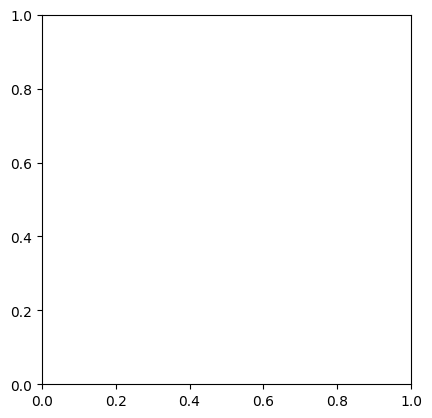

In [6]:
data=rootgrp['geophysical_data']['RI']
data=np.array(data)
plt.imshow(data)
plt.colorbar()
plt.show()

In [1]:
from rz_cvae.Crawler import Crawler
crawler=Crawler(slot=7, product='Chl')
df = crawler.organize_dataset(json_path = 'output')

initialized crawler with
                date: 2021/01/01 ~ 2021/01/02	downlad_dir: outputs	product: Chl	file_type: nc	dap_web: http://nosc.elecocean.co.kr:8080/opendap/GOCI-II/


In [2]:
df

,id,product,datetime,path,format,fillvalue,npy
0,GK2B_GOCI2_L2_20210101_011530_LA_S007_Chl.nc,Chl,20210101_012559,outputs\GK2B_GOCI2_L2_20210101_011530_LA_S007_...,nc,-999.0,npy\GK2B_GOCI2_L2_20210101_011530_LA_S007_Chl.nc
1,GK2B_GOCI2_L2_20210101_011530_LA_S007_RI.nc,RI,20210101_012559,outputs\GK2B_GOCI2_L2_20210101_011530_LA_S007_...,nc,-32768.0,npy\GK2B_GOCI2_L2_20210101_011530_LA_S007_RI.nc
2,GK2B_GOCI2_L2_20210101_021530_LA_S007_Chl.nc,Chl,20210101_022545,outputs\GK2B_GOCI2_L2_20210101_021530_LA_S007_...,nc,-999.0,npy\GK2B_GOCI2_L2_20210101_021530_LA_S007_Chl.nc
3,GK2B_GOCI2_L2_20210101_021530_LA_S007_RI.nc,RI,20210101_022545,outputs\GK2B_GOCI2_L2_20210101_021530_LA_S007_...,nc,-32768.0,npy\GK2B_GOCI2_L2_20210101_021530_LA_S007_RI.nc
4,GK2B_GOCI2_L2_20210101_031530_LA_S007_Chl.nc,Chl,20210101_032545,outputs\GK2B_GOCI2_L2_20210101_031530_LA_S007_...,nc,-999.0,npy\GK2B_GOCI2_L2_20210101_031530_LA_S007_Chl.nc
5,GK2B_GOCI2_L2_20210101_031530_LA_S007_RI.nc,RI,20210101_032545,outputs\GK2B_GOCI2_L2_20210101_031530_LA_S007_...,nc,-32768.0,npy\GK2B_GOCI2_L2_20210101_031530_LA_S007_RI.nc
6,GK2B_GOCI2_L2_20210101_041530_LA_S007_Chl.nc,Chl,20210101_042545,outputs\GK2B_GOCI2_L2_20210101_041530_LA_S007_...,nc,-999.0,npy\GK2B_GOCI2_L2_20210101_041530_LA_S007_Chl.nc
7,GK2B_GOCI2_L2_20210101_041530_LA_S007_RI.nc,RI,20210101_042545,outputs\GK2B_GOCI2_L2_20210101_041530_LA_S007_...,nc,-32768.0,npy\GK2B_GOCI2_L2_20210101_041530_LA_S007_RI.nc
8,GK2B_GOCI2_L2_20210101_051530_LA_S007_Chl.nc,Chl,20210101_052545,outputs\GK2B_GOCI2_L2_20210101_051530_LA_S007_...,nc,-999.0,npy\GK2B_GOCI2_L2_20210101_051530_LA_S007_Chl.nc
9,GK2B_GOCI2_L2_20210101_051530_LA_S007_RI.nc,RI,20210101_052545,outputs\GK2B_GOCI2_L2_20210101_051530_LA_S007_...,nc,-32768.0,npy\GK2B_GOCI2_L2_20210101_051530_LA_S007_RI.nc


### how to store land flag?

# Failures: Missing nc(netCDF) files on Open API!
There is no netCDF or Image file exist. 

I planned update it to use OpenDAP api or open-api.   I've tried [open-api](https://www.nosc.go.kr/openapi/actionOpenApiIssue.do) first but there were only '.do' files!  
In the case of OPeNDAP, it seems like I should issue an id and password...  
Maybe it was just waste of time...

In [1]:
import urllib
import requests
import json
import pprint
import pandas as pd
import os
from pathlib import Path


In [2]:
auth_key = '' # issue key at this page https://www.nosc.go.kr/openapi/actionOpenApiIssue.do 


In [4]:
class GOCI2Downloader():
    """
    make request query to use open-API of GOCI-II sattelite,
    according to the document, 
    https://www.nosc.go.kr/boardContents/actionBoardContentsCons0010.do

    parameters: 
        slot = Division of region of GOCI-II. 13 means entire region.
    """
    def __init__(self, auth_key, start_date, end_date, slot='13', data_format="json", local_path="./download/"):
        self.date0 = str(start_date)
        self.date1 = str(end_date)
        self.auth_key = str(auth_key)
        self.slot = str(slot)
        self.format = str(data_format)
        self.local_path = local_path #local directory to save file


    def url(self):
        link=f'http://nosc.go.kr/openapi/GK2BMedia/search.do?ServiceKey={self.auth_key}&startDate={self.date0}&endDate={self.date1}&slot={self.slot}&ResultType={self.format}'
        return link

    def to_dataframe(self):
        r = requests.get(self.url())
        j = r.json()
        df = pd.DataFrame.from_dict(j)
        print('request result codes count(200 - okay, 400 failure):\n',df['resultCode'].value_counts())
        df = pd.DataFrame(df['data'].values.tolist())
        return df

    def download_file(self, url, local_path):
        """from Roman Podlinov, https://stackoverflow.com/a/16696317"""
        local_filename = url.split('/')[-1]
        # NOTE the stream=True parameter below
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            path = os.path.join(local_path, local_filename)
            with open(path, 'wb') as f:
                f.write(r.content)
        return local_filename

    def download_files(self, file_format='nc.nc4'):
        df = self.to_dataframe()
        df = df.loc[df['product']=='RI']
        urls = df['filePath'].apply(lambda x: x.replace('.do',('.'+file_format))) #where is netCDF4 files????
        Path(f"./{self.local_path}").mkdir(exist_ok=True)
        for url in urls:
            self.download_file(url, self.local_path)
            print(f"attempt to download {url} finished.")
            
    

In [5]:
downloader = GOCI2Downloader(auth_key, 20220901, 20220905)
req = downloader.url()
print(req)

http://nosc.go.kr/openapi/GK2BMedia/search.do?ServiceKey=d965791427d9b0266cd0d5786a998e75735d479fdad6fe291424d04d1f834530&startDate=20220901&endDate=20220905&slot=13&ResultType=json


In [6]:
df=downloader.to_dataframe()
df

request result codes count(200 - okay, 400 failure):
 200    3589
Name: resultCode, dtype: int64


,sateName,sensor,sateLevel,area,product,slot,filePath,fileName,obsTimeUTC,obsTimeKST
0,GK2B,GOCI-II,L1B,한반도,,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2_GOCI2_L1B_20220831_231500_RLA_1,2022-08-31 23:15:00,2022-09-01 08:15:00
1,GK2B,GOCI-II,L1B,한반도,,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2_GOCI2_L1B_20220901_001500_RLA_1,2022-09-01 00:15:00,2022-09-01 09:15:00
2,GK2B,GOCI-II,L1B,한반도,,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2_GOCI2_L1B_20220901_011500_RLA_1,2022-09-01 01:15:00,2022-09-01 10:15:00
3,GK2B,GOCI-II,L1B,한반도,,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2_GOCI2_L1B_20220901_021500_RLA_1,2022-09-01 02:15:00,2022-09-01 11:15:00
4,GK2B,GOCI-II,L1B,한반도,,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2_GOCI2_L1B_20220901_031500_RLA_1,2022-09-01 03:15:00,2022-09-01 12:15:00
...,...,...,...,...,...,...,...,...,...,...
3584,GK2B,GOCI-II,L2,한반도,Kd_660,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2B_GOCI2_L2_20220904_081530_LA_Kd_660,2022-09-04 08:15:30,2022-09-04 17:15:30
3585,GK2B,GOCI-II,L2,한반도,IOP_bb555,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2B_GOCI2_L2_20220904_081530_LA_IOP_bb555,2022-09-04 08:15:30,2022-09-04 17:15:30
3586,GK2B,GOCI-II,L2,한반도,IOP_bb412,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2B_GOCI2_L2_20220904_081530_LA_IOP_bb412,2022-09-04 08:15:30,2022-09-04 17:15:30
3587,GK2B,GOCI-II,L2,한반도,IOP_a745,13,http://www.khoa.go.kr/nosc/data/satellite/GK2B...,GK2B_GOCI2_L2_20220904_081530_LA_IOP_a745,2022-09-04 08:15:30,2022-09-04 17:15:30


In [7]:
downloader.download_files()

request result codes count(200 - okay, 400 failure):
 200    3589
Name: resultCode, dtype: int64
attempt to download http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/08/31/GK2B_GOCI2_L2_20220831_231530_LA_RI.nc.nc4 finished.
attempt to download http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_001530_LA_RI.nc.nc4 finished.
attempt to download http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_011530_LA_RI.nc.nc4 finished.
attempt to download http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_021530_LA_RI.nc.nc4 finished.
attempt to download http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_031530_LA_RI.nc.nc4 finished.
attempt to download http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_041530_LA_RI.nc.nc4 finished.
attempt to download http://www.khoa.go.kr/nos

In [8]:
print(df.loc[df['product']=='RI']['filePath'].values)

['http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/08/31/GK2B_GOCI2_L2_20220831_231530_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_001530_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_011530_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_021530_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_031530_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_041530_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_051530_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_061630_LA_RI.do'
 'http://www.khoa.go.kr/nosc/data/satellite/GK2B/GOCI-II/L1B/2022/09/01/GK2B_GOCI2_L2_20220901_071530_LA